# ADQL Query examples

<img style="position: absolute; right: 60px; top: 40px; height: 160px; width: 160px" src="https://datalabs.esa.int/datalab-icon/c11e47af-7ce9-4281-b3b5-475a180a256f" /> 


<div style="width: 70%;">

Copyright (c) European Space Agency, 2025.

This file is subject to the terms and conditions defined in file LICENSE.txt, which is part of this source code package. No part of the package, including this file, may be copied, modified, propagated, or distributed except according to the terms contained in the file LICENSE.txt.

</div>

**Last modified:** 27.11.2025

**Last update:** Align ADQL queries with Euclid Archive schema names.

**Notebook summary**

This notebook includes the ADQL Query examples that are directly accessible from the Euclid Archive WEB interface.

1. To facilitate the navigation through this notebook, only the first 3 lines of the retrieved tables are displayed when the downloaded table contains > 10 rows. This can be easily adjusted or modified below.
2. The ADQL queries are designed to not exceed 1 minute execution time. Currently, most queries are finished in <5 seconds, but their execution time once PDR is public will increase.
3. the ADQL queries are set using the [Python f-string](https://docs.python.org/3/tutorial/inputoutput.html). This approach improves the user experience as it allows to easily modify the optional parts of the query. At the same time, I have tried to not "abuse" of this utility to balance the readibility and interactivity of the examples.

**Some useful links:**
* [Euclid Q1 data product description](https://euclid.esac.esa.int/dr/q1/dpdd/index.html)
* [Astroquery.Euclid documentation content](https://astroquery.readthedocs.io/en/latest/esa/euclid/euclid.html)
* [Astroquery.EuclidClass help content](https://astroquery.readthedocs.io/en/latest/api/astroquery.esa.euclid.EuclidClass.html#astroquery.esa.euclid.EuclidClass)
* [Astropy table documentation](https://docs.astropy.org/en/stable/table/index.html)
* [Gaia Archive: TAP and ADQL](https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries)

**Running the notebook:** This notebook has **read-only permissions**. You can still run and edit cells but if you would like to save your changes then you have to save the notebook to a different location - your workspace for example. The notebook is intended to be run using the **EUCLID-TOOLS kernel** that has all the necessary packages included.

***

In [2]:
#installing necessary packages
from astroquery.esa.euclid.core import Euclid
from astropy import wcs
import pandas as pd
import astropy.units as u
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
from astropy.visualization import astropy_mpl_style, ImageNormalize, PercentileInterval, AsinhStretch, LogStretch

from astroquery.simbad import Simbad
import matplotlib.pyplot as plt

plt.style.use(astropy_mpl_style)
import os

First let's make a folder (if not already created) to save the output files from this notebook. All the example notebooks save their outputs to this same folder in your user workspace called: `'example_notebook_outputs/'`

In [2]:
#making a folder for the output files
output_folder= '/media/user/example_notebook_outputs/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
Euclid.login()

# Alternative ways to login; uncomment your preferred one: ===========
# Euclid.login_gui()                                          # Login via graphic interface (pop-up window)
# Euclid.login(user='<user name>', password='<password>')     # 
# Euclid.login(credentials_file='<path to credentials file>') # Login using a credentials file - The file must contain just two rows: the user name (first row) and the password.
# Euclid.logout()

INFO: Login to Euclid TAP server: eas.esac.esa.int:443/tap-server/tap/ [astroquery.esa.euclid.core]


## 1. Loading tables

### 1.1 load_tables - Load all public data tables metadata

The [load_tables](https://astroquery.readthedocs.io/en/latest/api/astroquery.utils.tap.TapPlus.html#astroquery.utils.tap.TapPlus.load_tables) method returns a list of table (objects) hosted by the Archive.

In [5]:
tables = Euclid.load_tables(only_names=True, include_shared_tables=True)
print(f'* Found {len(tables)} tables')

for table in (tables[0:5]):                # Remove the "[0:5]" to list all the public tables
    print(table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
* Found 107 tables
catalogue.mer_catalogue
catalogue.mer_cutouts
catalogue.mer_morphology
catalogue.phz_classification
catalogue.phz_galaxy_sed


### 1.2 load_table - Load metadata for a specified table

If the user is logged in, the table can refer to a table in the user's private area. The method returns a tap table metadata object.

| Input parameter | Type | Mandatory | Default | Description |
| --- | --- | --- | --- | --- |
| table | str | yes| - | Full qualified table name (i.e. schema name + table name)
| verbose | bool | no | False | Flag to display information about the process 

In [6]:
#getting all columns for the sedm.calibrated_frame table
table = Euclid.load_table(table="sedm.calibrated_frame", verbose=False)
print(table)
print()
print('Columns: ')
for column in table.columns[0:5]:                # Remove the "[0:5]" to list all the public tables
    print(f' * {column.name}')

TAP Table name: sedm.calibrated_frame
Description: None
Size (bytes): 0
Num. columns: 36

Columns: 
 * calibrated_frame_oid
 * category
 * creation_date
 * datalabs_path
 * data_release_oid


## 2. Cone search


The [cone_search](https://astroquery.readthedocs.io/en/latest/api/astroquery.esa.euclid.EuclidClass.html#astroquery.esa.euclid.EuclidClass.cone_search) method implements one of the most popular use cases when connecting to an astronomy archive: retrieving data around a projected circular region in a given sky location from a given catalogue. The example below shows how to launch a 0.1 degrees radius cone search around NGC 6505. By default, this method targets the "mer_catalogue" and its outcome is restricted to 50 rows. This limitation can be removed by setting the ROW_LIMIT attribute to "-1" (see the next example below).

In [7]:
# selecting source coordinates based on chosen archive env (to make sure source exists)
simbad_source = Simbad.query_object('NGC 6505')
coords        = SkyCoord(simbad_source['ra'][0], simbad_source['dec'][0], frame='icrs', unit='deg')

In [8]:
radius = u.Quantity(0.1, u.deg)
job    = Euclid.cone_search(coordinate=coords, radius=radius, columns="*", async_job=True)

res    = job.get_results()
print(f"* Found {len(res)} results")
res[:3]   # Remove the "[0:5]" to visualise the full job output.

INFO: Query finished. [astroquery.utils.tap.core]
* Found 50 results


basic_download_data_oid,to_be_published,object_id,right_ascension,declination,right_ascension_psf_fitting,declination_psf_fitting,segmentation_map_id,vis_det,flux_vis_1fwhm_aper,flux_vis_2fwhm_aper,flux_vis_3fwhm_aper,flux_vis_4fwhm_aper,flux_y_1fwhm_aper,flux_y_2fwhm_aper,flux_y_3fwhm_aper,flux_y_4fwhm_aper,flux_j_1fwhm_aper,flux_j_2fwhm_aper,flux_j_3fwhm_aper,flux_j_4fwhm_aper,flux_h_1fwhm_aper,flux_h_2fwhm_aper,flux_h_3fwhm_aper,flux_h_4fwhm_aper,flux_nir_stack_1fwhm_aper,flux_nir_stack_2fwhm_aper,flux_nir_stack_3fwhm_aper,flux_nir_stack_4fwhm_aper,flux_u_ext_decam_1fwhm_aper,flux_u_ext_decam_2fwhm_aper,flux_u_ext_decam_3fwhm_aper,flux_u_ext_decam_4fwhm_aper,flux_g_ext_decam_1fwhm_aper,flux_g_ext_decam_2fwhm_aper,flux_g_ext_decam_3fwhm_aper,flux_g_ext_decam_4fwhm_aper,flux_r_ext_decam_1fwhm_aper,flux_r_ext_decam_2fwhm_aper,flux_r_ext_decam_3fwhm_aper,flux_r_ext_decam_4fwhm_aper,flux_i_ext_decam_1fwhm_aper,flux_i_ext_decam_2fwhm_aper,flux_i_ext_decam_3fwhm_aper,flux_i_ext_decam_4fwhm_aper,flux_z_ext_decam_1fwhm_aper,flux_z_ext_decam_2fwhm_aper,flux_z_ext_decam_3fwhm_aper,flux_z_ext_decam_4fwhm_aper,flux_u_ext_lsst_1fwhm_aper,flux_u_ext_lsst_2fwhm_aper,flux_u_ext_lsst_3fwhm_aper,flux_u_ext_lsst_4fwhm_aper,flux_g_ext_lsst_1fwhm_aper,flux_g_ext_lsst_2fwhm_aper,flux_g_ext_lsst_3fwhm_aper,flux_g_ext_lsst_4fwhm_aper,flux_r_ext_lsst_1fwhm_aper,flux_r_ext_lsst_2fwhm_aper,flux_r_ext_lsst_3fwhm_aper,flux_r_ext_lsst_4fwhm_aper,flux_i_ext_lsst_1fwhm_aper,flux_i_ext_lsst_2fwhm_aper,flux_i_ext_lsst_3fwhm_aper,flux_i_ext_lsst_4fwhm_aper,flux_z_ext_lsst_1fwhm_aper,flux_z_ext_lsst_2fwhm_aper,flux_z_ext_lsst_3fwhm_aper,flux_z_ext_lsst_4fwhm_aper,flux_u_ext_megacam_1fwhm_aper,flux_u_ext_megacam_2fwhm_aper,flux_u_ext_megacam_3fwhm_aper,flux_u_ext_megacam_4fwhm_aper,flux_r_ext_megacam_1fwhm_aper,flux_r_ext_megacam_2fwhm_aper,flux_r_ext_megacam_3fwhm_aper,flux_r_ext_megacam_4fwhm_aper,flux_g_ext_jpcam_1fwhm_aper,flux_g_ext_jpcam_2fwhm_aper,flux_g_ext_jpcam_3fwhm_aper,flux_g_ext_jpcam_4fwhm_aper,flux_i_ext_panstarrs_1fwhm_aper,flux_i_ext_panstarrs_2fwhm_aper,flux_i_ext_panstarrs_3fwhm_aper,flux_i_ext_panstarrs_4fwhm_aper,flux_z_ext_panstarrs_1fwhm_aper,flux_z_ext_panstarrs_2fwhm_aper,flux_z_ext_panstarrs_3fwhm_aper,flux_z_ext_panstarrs_4fwhm_aper,flux_g_ext_hsc_1fwhm_aper,flux_g_ext_hsc_2fwhm_aper,flux_g_ext_hsc_3fwhm_aper,flux_g_ext_hsc_4fwhm_aper,flux_z_ext_hsc_1fwhm_aper,flux_z_ext_hsc_2fwhm_aper,flux_z_ext_hsc_3fwhm_aper,flux_z_ext_hsc_4fwhm_aper,fluxerr_vis_1fwhm_aper,fluxerr_vis_2fwhm_aper,fluxerr_vis_3fwhm_aper,fluxerr_vis_4fwhm_aper,fluxerr_y_1fwhm_aper,fluxerr_y_2fwhm_aper,fluxerr_y_3fwhm_aper,fluxerr_y_4fwhm_aper,fluxerr_j_1fwhm_aper,fluxerr_j_2fwhm_aper,fluxerr_j_3fwhm_aper,fluxerr_j_4fwhm_aper,fluxerr_h_1fwhm_aper,fluxerr_h_2fwhm_aper,fluxerr_h_3fwhm_aper,fluxerr_h_4fwhm_aper,fluxerr_nir_stack_1fwhm_aper,fluxerr_nir_stack_2fwhm_aper,fluxerr_nir_stack_3fwhm_aper,fluxerr_nir_stack_4fwhm_aper,fluxerr_u_ext_decam_1fwhm_aper,fluxerr_u_ext_decam_2fwhm_aper,fluxerr_u_ext_decam_3fwhm_aper,fluxerr_u_ext_decam_4fwhm_aper,fluxerr_g_ext_decam_1fwhm_aper,fluxerr_g_ext_decam_2fwhm_aper,fluxerr_g_ext_decam_3fwhm_aper,fluxerr_g_ext_decam_4fwhm_aper,fluxerr_r_ext_decam_1fwhm_aper,fluxerr_r_ext_decam_2fwhm_aper,fluxerr_r_ext_decam_3fwhm_aper,fluxerr_r_ext_decam_4fwhm_aper,fluxerr_i_ext_decam_1fwhm_aper,fluxerr_i_ext_decam_2fwhm_aper,fluxerr_i_ext_decam_3fwhm_aper,fluxerr_i_ext_decam_4fwhm_aper,fluxerr_z_ext_decam_1fwhm_aper,fluxerr_z_ext_decam_2fwhm_aper,fluxerr_z_ext_decam_3fwhm_aper,fluxerr_z_ext_decam_4fwhm_aper,fluxerr_u_ext_lsst_1fwhm_aper,fluxerr_u_ext_lsst_2fwhm_aper,fluxerr_u_ext_lsst_3fwhm_aper,fluxerr_u_ext_lsst_4fwhm_aper,fluxerr_g_ext_lsst_1fwhm_aper,fluxerr_g_ext_lsst_2fwhm_aper,fluxerr_g_ext_lsst_3fwhm_aper,fluxerr_g_ext_lsst_4fwhm_aper,fluxerr_r_ext_lsst_1fwhm_aper,fluxerr_r_ext_lsst_2fwhm_aper,fluxerr_r_ext_lsst_3fwhm_aper,fluxerr_r_ext_lsst_4fwhm_aper,fluxerr_i_ext_lsst_1fwhm_aper,fluxerr_i_ext_lsst_2fwhm_aper,fluxerr_i_ext_lsst_3fwhm_a

The example below shows how to 1) remove the row limitation, and 2) target a different table. It also shows that the cone_search method accepts target names of coordinates, provided that the name is recognised by the Simbad, VizieR, or NED services.

In [9]:
radius           = u.Quantity(0.2, u.deg)
Euclid.ROW_LIMIT = -1               # Set this attribute to -1 to retrieve the full output of the cone_search method.
job              = Euclid.cone_search(coordinate='NGC 6505', radius=radius, table_name="q1.calibrated_frame", ra_column_name="ra", dec_column_name="dec", async_job=True, columns = '*')
res              = job.get_results()
print(f"* Found {len(res)} results")
res[0:2]

INFO: Query finished. [astroquery.utils.tap.core]
* Found 14 results


calibrated_frame_oid,category,creation_date,datalabs_path,data_release_oid,dec,duration,end_time,field_id,file_checksum,file_name,file_path,filter_name,first_type,fov,frame_seq,instrument_name,observation_date_time_utc,observation_id,pa,patch_id,pointing_id,product_id,product_type,provenance_id,published,ra,release_date,release_name,second_type,start_time,start_time_mjd,stc_s,stype,technique,to_be_published,dist
int64,str7,str23,str35,int64,float64,float64,str24,int64,str32,str65,str47,str5,str6,str1039,int64,str4,str23,int64,float64,int64,int64,str114,str25,int64,int64,float64,int64,str5,str5,str23,float64,str995,str4,str5,int64,float64
2475,SCIENCE,2024-10-17T04:30:56.18,/data/euclid_q1/Q1_R1/VIS_QUAD/2704,1,65.60351547,89.52,2024-07-18T20:42:27.118,--,71b9520d8826272438ab177839cd93de,EUC_VIS_SWL-DET-002704-00-2-0000000__20241017T042759.344384Z.fits,/euclid/repository_idr/iqr1/Q1_R1/VIS_QUAD/2704,VIS,SURVEY,"(266.86212024950595, 65.71624060009374, 266.8623773095572, 65.71631036075286, 266.9788549982069, 65.74786635167267, 267.01542914463573, 65.75772624369438, 267.1325479299924, 65.789075357991, 267.2503325942465, 65.82037444678905, 267.4054514796159, 65.86119713261729, 267.5608756479171, 65.90203562442424, 267.67991819938504, 65.93292251844574, 267.79904029676203, 65.96360327233376, 267.8365262059458, 65.97322292804505, 267.95609142638006, 66.00370272966312, 268.0762117342809, 66.03410503359136, 268.2340145636945, 66.07348648140555, 268.3547835749697, 66.1035211117248, 268.5061846257949, 66.005607870456, 268.5792304000563, 65.9578287810706, 268.6520954730107, 65.9099292067711, 268.80699503213117, 65.8076323044296, 268.87936693489377, 65.75931750867193, 268.9515914789596, 65.71085725392439, 269.0279270159219, 65.65928121420973, 269.1043096203999, 65.60753203492119, 269.17582393782016, 65.55873542699251, 269.2471583757394, 65.50981928003661, 267.64886630064615, 65.09737198212221, 266.7460871514171, 65.68457873329419)",0,VIS,2024-07-18T20:40:57.598,2704,327.8679842,--,11921,VIS_ProcessField_EUCLID_2.0.15-QUICK_RELEASE-glibet-PLAN-000000-WXUOGB6H-20241016-162825-23-dpdcalibrated_frames-1,DpdVisCalibratedQuadFrame,4,0,267.99354663,--,Q1_R1,OTHER,2024-07-18T20:40:57.598,60509.86177776208,Polygon J2000 266.8621202495062 65.7162406000935 266.8623773095575 65.71631036075266 266.9788549982071 65.74786635167276 267.01542914463585 65.75772624369452 267.1325479299926 65.7890753579911 267.25033259424663 65.82037444678915 267.4054514796158 65.86119713261732 267.5608756479172 65.90203562442422 267.67991819938493 65.9329225184457 267.79904029676186 65.96360327233371 267.8365262059456 65.97322292804516 267.95609142638017 66.00370272966309 268.0762117342807 66.03410503359146 268.2340145636943 66.0734864814054 268.35478357496976 66.10352111172466 268.50618462579513 66.00560787045605 268.5792304000566 65.95782878107048 268.6520954730105 65.90992920677093 268.80699503213094 65.80763230442938 268.87936693489354 65.75931750867214 268.9515914789594 65.71085725392442 269.0279270159221 65.65928121420994 269.10430962039976 65.60753203492102 269.17582393782044 65.55873542699261 269.24715837573916 65.50981928003667 267.64886630064615 65.09737198212231 266.74608715141727 65.68457873329434,QUAD,IMAGE,1,0.11414714851731637
1427,SCIENCE,2024-09-30T19:20:24.788,/data/euclid_q1/Q1_R1/NIR/2704,1,65.60351547,87.2448,2024-07-18T20:40:07.6018,0,d8f83f26c263fd62b199f619ea532673,EUC_NIR_W-CAL-IMAGE_H-2704-0_20240930T191946.868701Z.fits,/euclid/repository_idr/iqr1/Q1_R1/NIR/2704,NIR_H,SURVEY,"(267.07575601979966, 65.80559495277177, 267.1343074804666, 65.8213396472812, 267.5314798468003, 65.92644380011504, 267.8826334539393, 66.01644061280211, 267.9425445048986, 66.0315539360263, 268.2960548465599, 66.11982972663542, 268.53280524754575, 65.96456362608482, 268.76615005408104, 65.80838900146342, 268.9959227016252, 65.65160363065196, 269.2034553083738, 65.50690466896813, 267.6715585947429, 65.11149076298081, 266.7336771651373, 65.712796373753)",0,NISP,2024-07-18T20:38:4

**Notes:**

* Once the table_name, ra_column_name, and dec_column_name arguments are set by the user, the method does not recognise the default values. This is a known issue.
* Users are stronlgy adviced to use the [cone_search](https://astroquery.readthedocs.io/en/latest/api/astroquery.esa.euclid.EuclidClass.html#astroquery.esa.euclid.EuclidClass.cone_search) method instead of the [query_object](https://astroquery.readthedocs.io/en/latest/api/astroquery.esa.euclid.EuclidClass.html#astroquery.esa.euclid.EuclidClass.query_object) method. The latter makes use of the ADQL BOX function that is deprecated
and can yield misleading results due to a geometric projection effect.

## 3. Launching jobs

### 3.1 Synchronous query

This is the recommended mode for queries that do not require excesive computation time and/or that generate relatively small results - for details please see the Gaia Archive FAQ: [Why does my query time out after 90 minutes? Why is my query limited to 3 million rows?](https://www.cosmos.esa.int/web/gaia/faqs#account-limits-2020>). This function is implemented by the [launch_job](https://astroquery.readthedocs.io/en/latest/api/astroquery.esa.euclid.EuclidClass.html#astroquery.esa.euclid.EuclidClass.launch_job) method.
Note that:
* The output of sync queries is limited to 2,000 rows if the query execution time exceeds 30(60) seconds for anonymous (registered) users.
* The job result ("res") below is an [Astropy table](https://docs.astropy.org/en/stable/table/index.html) object. The example shows how to store it locally in [VOTable](https://www.ivoa.net/documents/VOTable/20250116/) format.

In [10]:
query = f"SELECT object_id, right_ascension, declination, segmentation_area, ellipticity, kron_radius FROM mer_catalogue WHERE ellipticity > 0"
job   = Euclid.launch_job(query)
res   = job.get_results()
print(f'* Output table contains {len(res)} rows')

res[0:3]

* Output table contains 2000 rows


object_id,right_ascension,declination,segmentation_area,ellipticity,kron_radius
int64,float64,float64,int64,float64,float64
-636976105475231675,63.69761050376793,-47.523167515947385,16,0.7137373685836792,23.009674072265625
-640879164475225659,64.08791645514133,-47.52256594875536,37,0.6521082520484924,26.744855880737305
-634517503475224519,63.45175032607254,-47.52245191699526,70,0.45704805850982666,18.48931121826172


### 3.2. launch_job_async - Make an asynchronous query

This is the recommended mode for queries that are expected to output more than 2,000 rows and that require substantial execution time (noting that all the queries time out after 7200 seconds), and in this package it is implemented by the
[launch_job_async](https://astroquery.readthedocs.io/en/latest/api/astroquery.esa.euclid.EuclidClass.html#astroquery.esa.euclid.EuclidClass.launch_job_async) method. The query results are stored in the Archive (during 72 hours for anonymous users, and on the user area until the user deletes them for registered users). 
The example below generates a cone search combined with a constraint applied to the ellipticity, and is similar to the first ADQL query example listed in the [Euclid Archive](https://eas.esac.esa.int/sas/) (see its "Search/ADQL FORM" subtab).
For more ADQL examples please have a look at the Gaia Archive Help content (in particular, the [writting queries](https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries) section).

Note: It is a good practise to - from time to time - remove all jobs from the user space. The Gaia Archive FAQ [Is it possible to delete all the jobs (or a selection of them) in my job list at once?](https://www.cosmos.esa.int/web/gaia/faqs#delete-jobs-2020) shows how to do this programmatically - In the example code, simply replace "Gaia" by "Euclid" where needed.

In [12]:
query = """SELECT right_ascension, declination, object_id, vis_det, det_quality_flag, flux_detection_total, flux_vis_sersic, segmentation_area, kron_radius, DISTANCE(267.78, 65.53, right_ascension, declination) AS dist
FROM mer_catalogue
WHERE DISTANCE(267.78, 65.53, right_ascension, declination) < 0.1 AND
ellipticity > 0"""
print(f' * Launching ADQL query: ')
print(query)

job   = Euclid.launch_job_async(query, verbose=False)
print(job)  # This prints the job metadata (like "JObID", "Phase", "Owner", ...)

res   = job.get_results()
print(f"Found {len(res)} query results")
res[0:3]

 * Launching ADQL query: 
SELECT right_ascension, declination, object_id, vis_det, det_quality_flag, flux_detection_total, flux_vis_sersic, segmentation_area, kron_radius, DISTANCE(267.78, 65.53, right_ascension, declination) AS dist
FROM mer_catalogue
WHERE DISTANCE(267.78, 65.53, right_ascension, declination) < 0.1 AND
ellipticity > 0
INFO: Query finished. [astroquery.utils.tap.core]
<Table length=15129>
        name          dtype 
-------------------- -------
     right_ascension float64
         declination float64
           object_id   int64
             vis_det   int64
    det_quality_flag   int64
flux_detection_total float64
     flux_vis_sersic float64
   segmentation_area   int64
         kron_radius float64
                dist float64
Jobid: 1764240408541TPDR
Phase: COMPLETED
Owner: None
Output file: async_20251127104648.csv
Results: None
Found 15129 query results


right_ascension,declination,object_id,vis_det,det_quality_flag,flux_detection_total,flux_vis_sersic,segmentation_area,kron_radius,dist
float64,float64,int64,int64,int64,float64,float64,int64,float64,float64
267.8007183299202,65.43077069259559,2678007183654307706,1,2,3.303119659423828,3.1258363723754883,257,24.9636173248291,0.09960112595660932
267.81347229955026,65.43376784423499,2678134722654337678,1,0,0.2972785234451294,0.2499639391899109,53,18.347612380981445,0.09722946762358776
267.73787120423793,65.43489754122781,2677378712654348975,1,0,0.08075621724128723,0.10290417075157166,14,6.5500030517578125,0.0966959477506201


## 4. Getting products

In addition to catalogues that can be queried via [ADQL](https://www.ivoa.net/documents/ADQL/20231215/index.html),, the Euclid Archive also host the Euclid products: the FITS files that contain the different types or products (images, spectra, catalogues) generated by this mission. A popular use case is "I want to download the Euclid image of my favourite object". In order to do this, one must know the coordinates of the selected object, the instrument that was used to acquire the observation, and the type of product (e.g. raw, calibrated, mosaic, ...) that one wants to inspect. In the next example we proceed in two steps (see below).

**Step 1:**

First, we query the "mosaic_product" TAP table that contains the names of the FITS files with the background-subtracted mosaic images (associated with the Euclid product: [DpdMerBksMosaic](https://euclid.esac.esa.int/dr/q1/dpdd/merdpd/dpcards/mer_bksmosaic.html)) and their sky coverage (in its "fov" field). For this example we are targeting the images that include observations that cover the coordinates of NGC 6505. In the query below note:

1. the use of the "instrument_name" field to only select "VIS" observations, 
2. the radius variable that indicates the minimum distance between the target coordinates and the edges of the images, and
3. the use of the INTERSECTS ADQL clause in combination with the CIRCLE function. The target coordinates correspond to NGC 6505.

In [13]:
# Target selection: ==================================================================================
simbad_source = Simbad.query_object('NGC 6505')
coords        = SkyCoord(simbad_source['ra'][0], simbad_source['dec'][0], frame='icrs', unit='deg')
radius        = 0.5/60.                                                                              # This radius indicate the minimum distance between the target coordinates and the image edges.

# ADQL query =========================================================================================
query     = f"""SELECT file_name, file_path, datalabs_path, instrument_name, filter_name, ra, dec, creation_date, product_type, patch_id_list, tile_index
FROM q1.mosaic_product
WHERE instrument_name = 'VIS'
AND INTERSECTS(CIRCLE({coords.ra.deg:3.4f}, {coords.dec.deg:3.4f}, {radius:3.4f}), fov)=1"""

print(f'* Launching ADQL query: ')
print(query)

job = Euclid.launch_job_async(query)
res = job.get_results()
res

* Launching ADQL query: 
SELECT file_name, file_path, datalabs_path, instrument_name, filter_name, ra, dec, creation_date, product_type, patch_id_list, tile_index
FROM q1.mosaic_product
WHERE instrument_name = 'VIS'
AND INTERSECTS(CIRCLE(267.7809, 65.5308, 0.0083), fov)=1
INFO: Query finished. [astroquery.utils.tap.core]


file_name,file_path,datalabs_path,instrument_name,filter_name,ra,dec,creation_date,product_type,patch_id_list,tile_index
str80,str51,str39,str3,str3,float64,float64,str23,str15,int64,int64
EUC_MER_BGSUB-MOSAIC-VIS_TILE102158889-F95D3B_20241025T024806.508980Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/VIS,/data/euclid_q1/Q1_R1/MER/102158889/VIS,VIS,VIS,267.3807789,65.4983,2024-10-26T12:57:21.177,DpdMerBksMosaic,49,102158889


**Step 2:**

Access to the image using the "datalabs_path" and "file_name" information. Note that opening and plotting the example images requires a few seconds.

Reading: /data/euclid_q1/Q1_R1/MER/102158889/VIS/EUC_MER_BGSUB-MOSAIC-VIS_TILE102158889-F95D3B_20241025T024806.508980Z_00.00.fits


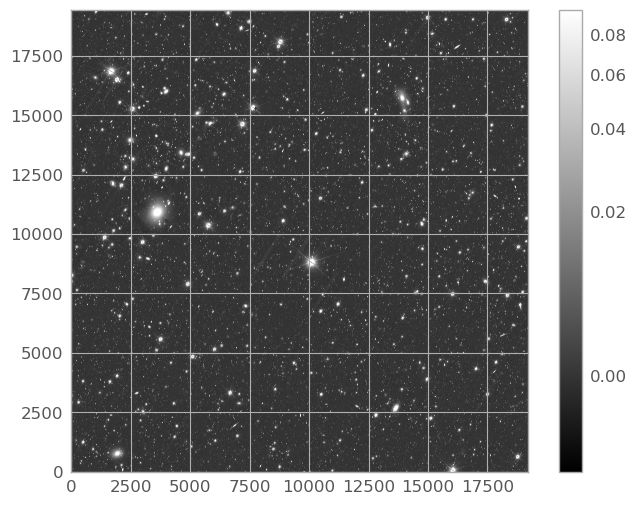

In [14]:
path_to_fits = f"{res['datalabs_path'][0]}/{res['file_name'][0]}"
hdul         = fits.open(path_to_fits)
print(f'Reading: {path_to_fits}')

image_data = hdul[0].data

plt.figure()
plt.imshow(image_data, cmap='gray', origin='lower', norm=ImageNormalize(image_data, interval=PercentileInterval(99.1), stretch=AsinhStretch()))
colorbar = plt.colorbar()
hdul.close()

# To export the image as png:
# png_name = path_to_fits[path_to_fits.rfind('/')+1:].replace('.fits','.png')
# plt.savefig(png_name, dpi=300, bbox_inches='tight', pad_inches=0)

## 6. Making MER cutouts


In many situations, users are only interested in downloading a small portion of the MER (background subtracted) Euclid image. The [get_cutout](https://astroquery.readthedocs.io/en/latest/api/astroquery.esa.euclid.EuclidClass.html#astroquery.esa.euclid.EuclidClass.get_cutout) method addresses this particular case, as it allows to download image cutouts and store them locally. For reference, downloading a 1'x1'cutout takes less than one second and the downloaded fits file weights ~5.5 MB.


**Note:** This method uses the astroquery cutout service to download a cutout fits image from the Archive, and it only works for MER images. The example below takes advantage of the Euclid data (FITS files) that are directly accessible from ESA Datalabs (no download needed). See also the dedicated [Cutouts.ipynb](Cutouts.ipynb) notebook that shows how to create cutouts from different types of Euclid images.

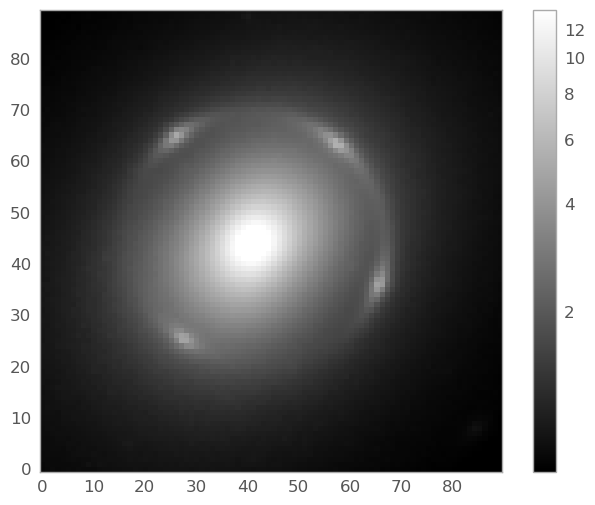

In [15]:
# Retrieve cutout ==============
file_path  = f"{res['datalabs_path'][0]}/{res['file_name'][0]}"

cutout_r      = 0.15 * u.arcmin 
hdul          = fits.open(file_path)
data          = hdul[0].data
header        = hdul[0].header
cutout_VIS    = Cutout2D(data=data, position = coords, size= cutout_r, wcs=wcs.WCS(header))



# Plot image ===================
plt.figure()
plt.imshow(cutout_VIS.data, cmap='gray', origin='lower', norm=ImageNormalize(cutout_VIS.data, interval=PercentileInterval(99.1), stretch=AsinhStretch()))
colorbar = plt.colorbar()
plt.grid(False)
hdul.close()

# To export the image as png:
# png_name = 'cutout_example.png'
# plt.savefig(png_name, dpi=300, bbox_inches='tight', pad_inches=0)

## 7. Spectra and DataLink service

[DataLink](https://www.ivoa.net/documents/DataLink/20231215/index.html) is a data access protocol compliant with the [IVOA](https://www.ivoa.net/) architecture that provides a linking mechanism between datasets offered by different services. In practice, it can be seen and used as a web service providing the list of additional
data products available for each object outside the main catalogue(s). For more information about the products served via DataLink in the [Euclid ESA Archive](https://eas.esac.esa.int/sas/) we recommend reading the Archive DataLink tutorials available at the Archive Help content (see the 
[Access to spectra](https://s2e2.cosmos.esa.int/www/ek_iscience/Access_to_spectra.html) section).

In the Archive the 1D Spectra data (noting that in Euclid Q1 only the blue part of the spectra is available) is served via the the Datalink_ service. This product is publicly available: there is no need to access as a registered user to retrieve it.
In order to access to this product, a two-step approach (as it happens with the Euclid products detailed in Sect. 5 and 6 above) is needed.

**Step 1:** 

First, you need to know the sources that have associated spectra. This information is included in the spectra_source table that can be accessed as follows:

In [16]:
query  = f"SELECT TOP 3 * FROM q1.spectra_source"
res    = Euclid.launch_job(query).get_results()
res

combined_spectra_fk,combined_spectra_product_fk,datalabs_path,dec_obj,dith_num,file_name,file_path,hdu_index,ra_obj,source_id,spectra_source_oid,to_be_published
int64,int64,str35,float64,int64,str61,str47,int64,float64,int64,int64,int64
241,12974,/data/euclid_q1/Q1_R1/SIR/102157951,64.1612659251953,2,EUC_SIR_W-COMBSPEC_102157951_2024-11-05T16:04:09.777246Z.fits,/euclid/repository_idr/iqr1/Q1_R1/SIR/102157951,705,264.889700912359,2648897009641612659,1038854,1
241,12968,/data/euclid_q1/Q1_R1/SIR/102157951,64.1070621509622,2,EUC_SIR_W-COMBSPEC_102157951_2024-11-05T16:03:52.723381Z.fits,/euclid/repository_idr/iqr1/Q1_R1/SIR/102157951,1697,265.011418797764,2650114187641070621,1038017,1
241,12968,/data/euclid_q1/Q1_R1/SIR/102157951,64.1264541322101,1,EUC_SIR_W-COMBSPEC_102157951_2024-11-05T16:03:52.723381Z.fits,/euclid/repository_idr/iqr1/Q1_R1/SIR/102157951,1378,264.984761444324,2649847614641264541,1037984,1


**Step 2 (direct access to the spectra):** 

Access to the image using the "datalabs_path", "file_name", and "hdu_index" information. In this case, we recommend to first open the Multi-extension fits file with the [Astropy fits](https://docs.astropy.org/en/stable/io/fits/index.html) package, and convert the data to an [Astropy table](https://docs.astropy.org/en/stable/table/index.html) object to handle it easier.

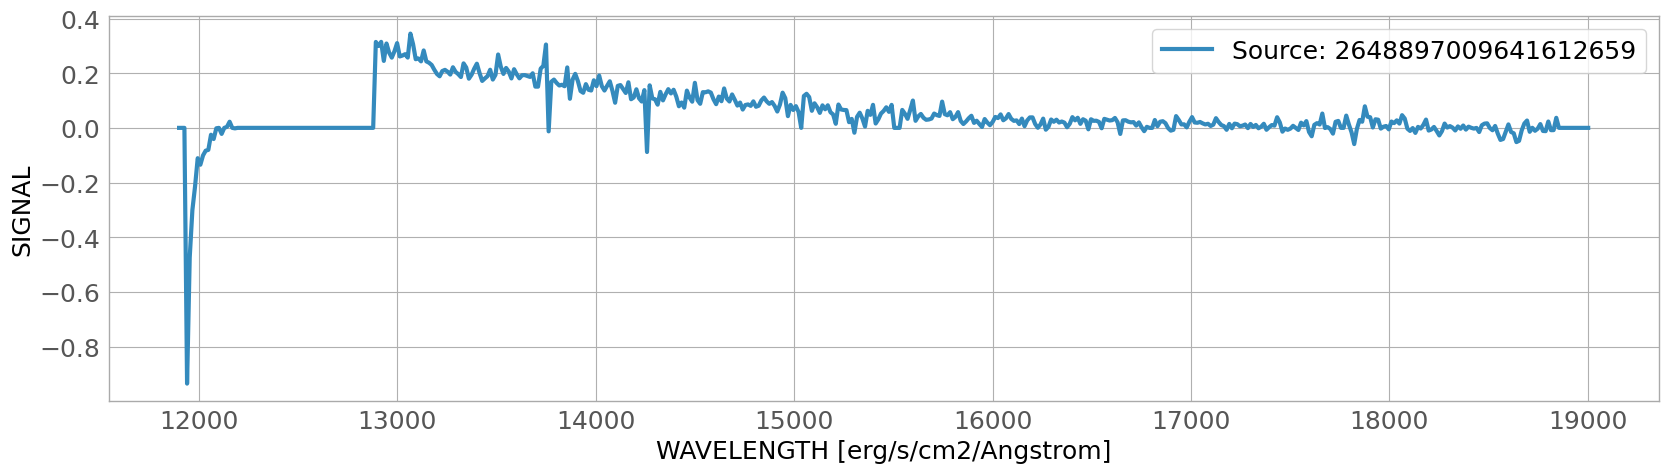

In [17]:
row_index    = 0 # To read the first row.
row          = res[row_index]
path_to_fits = f"{row['datalabs_path']}/{row['file_name']}"
hdu_index    = row['hdu_index']

hdul      = fits.open(path_to_fits)
spec_data = hdul[hdu_index].data
spec_data = Table(spec_data)
spec_head = hdul[hdu_index].header

# Plot the spectra ==========================================
fontsize = 18
fig = plt.figure(figsize = [20,5])
plt.plot(spec_data['WAVELENGTH'], spec_data['SIGNAL'], linewidth = 3, label = f"Source: {row['source_id']}")
plt.xlabel(f"WAVELENGTH [{spec_head['TUNIT2']}]", fontsize = fontsize)
plt.ylabel('SIGNAL', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.legend(fontsize = fontsize)
plt.show()